# CNN from scratch

In [16]:
import torch
import numpy as np
import os
import requests, zipfile, io
from torchvision import transforms, models
from torchsampler import ImbalancedDatasetSampler
from torchvision import datasets
from torchsummary import summary
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import splitfolders


## Data preparation

### Download

In [3]:
URL = 'https://udacity-dlnfd.s3-us-west-1.amazonaws.com/datasets/landmark_images.zip'
DATA_FOLDER = 'data'

if not(os.path.exists(DATA_FOLDER)):
    print(f"Downloading data to folder {DATA_FOLDER}")
    response = requests.get(URL)
    zipped_data = zipfile.ZipFile(io.BytesIO(response.content))
    zipped_data.extractall(DATA_FOLDER)
    print("Download complete and data extracted")
else:
    print(f"Data already download, check path {DATA_FOLDER}")

Download complete and data extracted


### Splitting data 

In [4]:
BATCH_SIZE = 30
NUM_WORKERS = 4
DATA_LOCATION = "data/landmark_images/"
SPLITS_RATIO = (.8, .2)
SEED = 1337

split = splitfolders.ratio(os.path.join(DATA_LOCATION, 'train'),
        output = os.path.join(DATA_LOCATION, 'split'),
        seed = SEED,
        ratio = SPLITS_RATIO,
        group_prefix=None
        )

train_dataset_path = os.path.join(DATA_LOCATION, 'split', 'train')
validation_dataset_path = os.path.join(DATA_LOCATION, 'split', 'val')
test_dataset_path = os.path.join(DATA_LOCATION, 'test')

Copying files: 4996 files [00:11, 447.96 files/s]


### Create DataLoaders

#### Transform Data

In [5]:
train_transform = transforms.Compose([
                    transforms.Resize([224,224]),
                    transforms.RandomVerticalFlip(),
                    transforms.RandomHorizontalFlip(), 
                    transforms.ColorJitter(brightness=0.3,
                                            contrast=0.2,
                                            saturation=0.3,
                                            hue=0.2),
                    transforms.ToTensor(),
                    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

valid_and_test_transform = transforms.Compose([
                    transforms.Resize([224,224]),
                    transforms.ToTensor(),
                    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

train_data = datasets.ImageFolder(train_dataset_path, transform=train_transform)
validation_data = datasets.ImageFolder(validation_dataset_path, transform=valid_and_test_transform)
test_data = datasets.ImageFolder(test_dataset_path, transform=valid_and_test_transform)


### Data loaders

In [9]:
train_loader = torch.utils.data.DataLoader(
            train_data,
            batch_size = BATCH_SIZE,
            sampler = ImbalancedDatasetSampler(train_data),
            num_workers = NUM_WORKERS,
)

validation_loader = torch.utils.data.DataLoader(
                validation_data,
                batch_size = BATCH_SIZE,
                shuffle = True
)

test_loader = torch.utils.data.DataLoader(
                test_data,
                batch_size = BATCH_SIZE
)

loaders_dict = {'train': train_loader, 'validation': validation_loader, 'test': test_loader}

In [11]:
print(f'Number of images for training is {len(train_data)}, for validation is {len(validation_data)}, and for testing is {len(test_data)}')
print(f'Total batches for training are {len(train_loader)}, for validation {len(validation_loader)} and for testing {len(test_loader)}')

Number of images for training is 3996, for validation is 1000, and for testing is 1250
Total batches for training are 134, for validation 34 and for testing 42


In [12]:
classes = [str(x)[3:].replace("_", " ") for x in train_data.classes]
classes

['Haleakala National Park',
 'Mount Rainier National Park',
 'Ljubljana Castle',
 'Dead Sea',
 'Wroclaws Dwarves',
 'London Olympic Stadium',
 'Niagara Falls',
 'Stonehenge',
 'Grand Canyon',
 'Golden Gate Bridge',
 'Edinburgh Castle',
 'Mount Rushmore National Memorial',
 'Kantanagar Temple',
 'Yellowstone National Park',
 'Terminal Tower',
 'Central Park',
 'Eiffel Tower',
 'Changdeokgung',
 'Delicate Arch',
 'Vienna City Hall',
 'Matterhorn',
 'Taj Mahal',
 'Moscow Raceway',
 'Externsteine',
 'Soreq Cave',
 'Banff National Park',
 'Pont du Gard',
 'Seattle Japanese Garden',
 'Sydney Harbour Bridge',
 'Petronas Towers',
 'Brooklyn Bridge',
 'Washington Monument',
 'Hanging Temple',
 'Sydney Opera House',
 'Great Barrier Reef',
 'Monumento a la Revolucion',
 'Badlands National Park',
 'Atomium',
 'Forth Bridge',
 'Gateway of India',
 'Stockholm City Hall',
 'Machu Picchu',
 'Death Valley National Park',
 'Gullfoss Falls',
 'Trevi Fountain',
 'Temple of Heaven',
 'Great Wall of China',

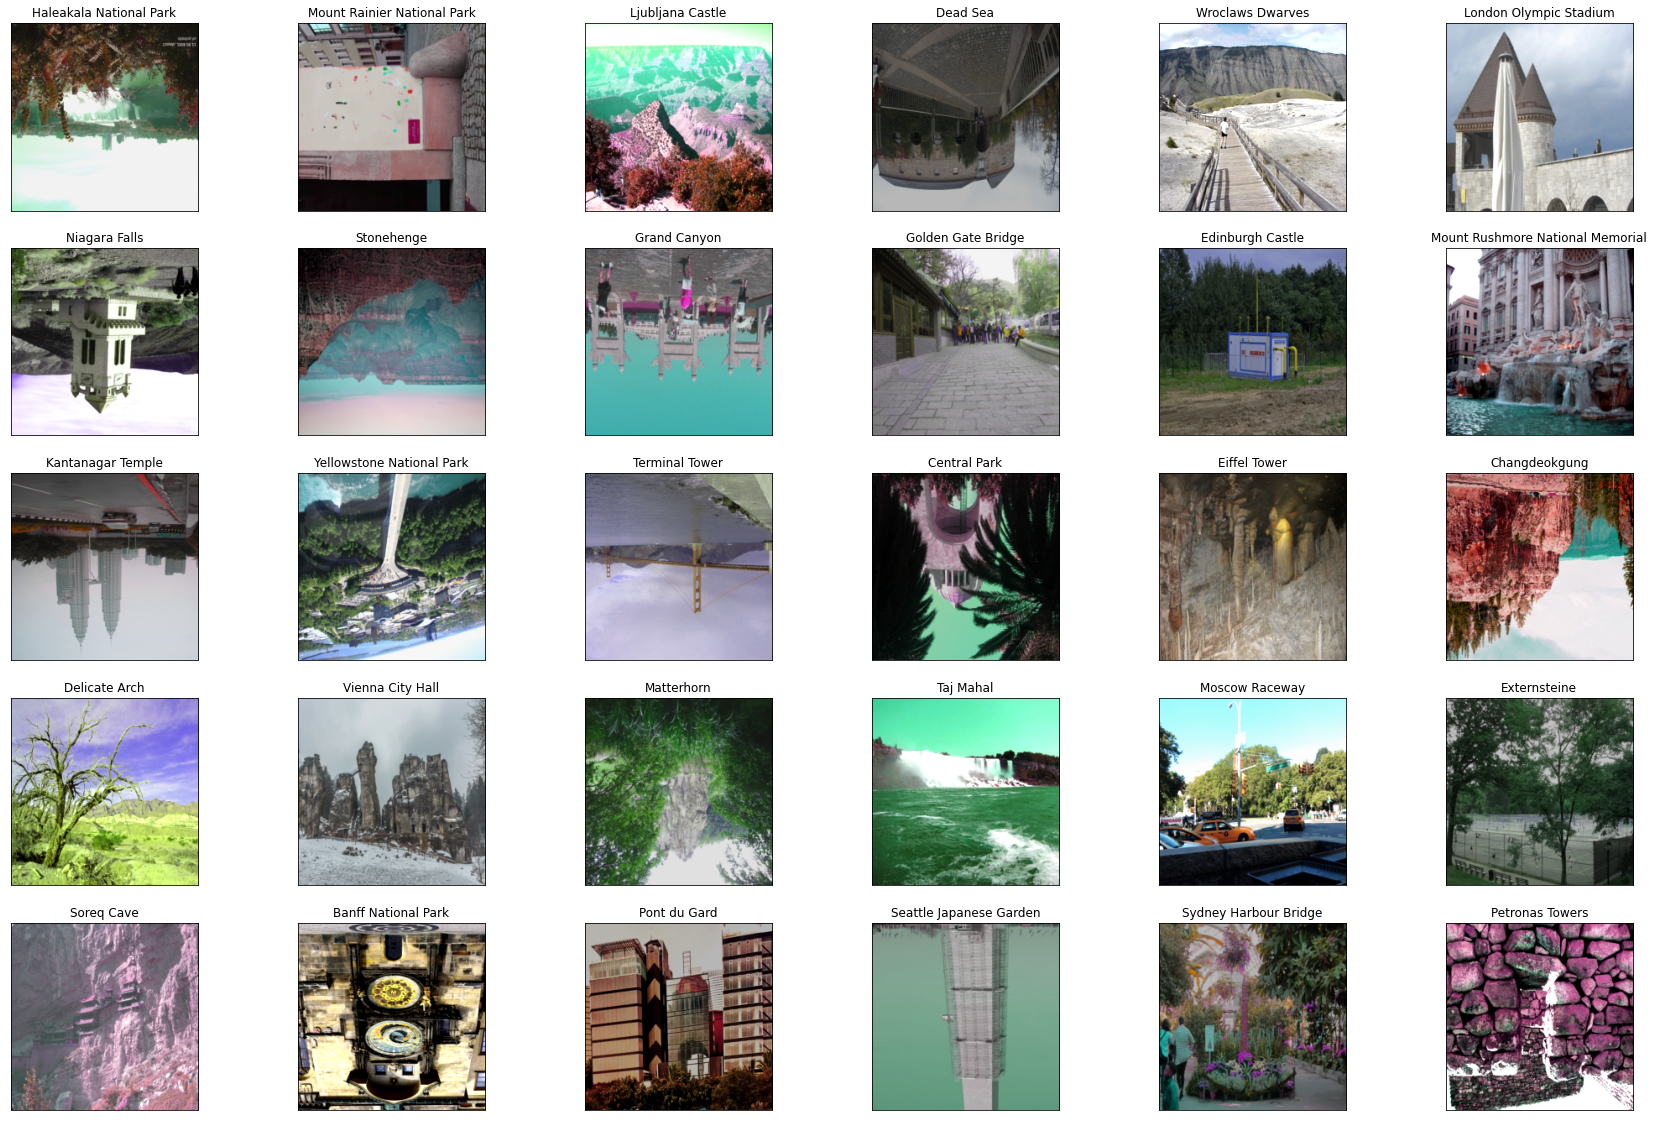

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_img(img):
    img = img /2 +0.5
    plt.imshow(np.transpose(img, (1,2,0)))

    
images, labels = next(iter(train_loader))
images = images.numpy()
    
fig = plt.figure(figsize=(30,20))

#Showing first 30 images
for idx, image in enumerate(images[0:30]):
    ax = fig.add_subplot(5,6, idx+1, xticks=[],yticks=[])
    show_img(images[idx])
    ax.set_title(classes[idx], wrap=True)
    

### Model Architecture

In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"We will train on {device}")

We will train on cuda


In [15]:
## Loss function

loss_func = nn.CrossEntropyLoss()

def get_optimizer(model, lr, momentum):
    return optim.SGD(model.parameters(), lr = lr, momentum = momentum)

def get_scheduler(optimizer):
    return optim.ReduceLROnPlateau(optimizer, mode = 'min', patience = 15)

In [17]:
cnn_model = nn.Sequential(nn.Conv2d(3, 16, 3, padding=1),
                        nn.LeakyReLU(),
                        nn.MaxPool2d(2, 2),
                        nn.Conv2d(16, 32, 3, padding=1),
                        nn.LeakyReLU(),
                        nn.MaxPool2d(2, 2),
                        nn.Conv2d(32, 64, 3, padding=1),
                        nn.LeakyReLU(),
                        nn.MaxPool2d(2, 2),
                        nn.Flatten(),
                        nn.Dropout(0.25),
                        nn.Linear(64*28*28, 1024),
                        nn.LeakyReLU(),
                        nn.Dropout(0.25),
                        nn.Linear(1024, 512),
                        nn.LeakyReLU(),
                        nn.Dropout(0.25),
                        nn.Linear(512, len(classes))
)

In [18]:
cnn_model.to(device)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): LeakyReLU(negative_slope=0.01)
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): LeakyReLU(negative_slope=0.01)
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): LeakyReLU(negative_slope=0.01)
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Dropout(p=0.25, inplace=False)
  (11): Linear(in_features=50176, out_features=1024, bias=True)
  (12): LeakyReLU(negative_slope=0.01)
  (13): Dropout(p=0.25, inplace=False)
  (14): Linear(in_features=1024, out_features=512, bias=True)
  (15): LeakyReLU(negative_slope=0.01)
  (16): Dropout(p=0.25, inplace=False)
  (17): Linear(in_features=512, out_features=50, 

In [19]:
summary(cnn_model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
         LeakyReLU-2         [-1, 16, 224, 224]               0
         MaxPool2d-3         [-1, 16, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]           4,640
         LeakyReLU-5         [-1, 32, 112, 112]               0
         MaxPool2d-6           [-1, 32, 56, 56]               0
            Conv2d-7           [-1, 64, 56, 56]          18,496
         LeakyReLU-8           [-1, 64, 56, 56]               0
         MaxPool2d-9           [-1, 64, 28, 28]               0
          Flatten-10                [-1, 50176]               0
          Dropout-11                [-1, 50176]               0
           Linear-12                 [-1, 1024]      51,381,248
        LeakyReLU-13                 [-1, 1024]               0
          Dropout-14                 [-